In [ ]:
pip install e2cnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 27.3 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Pad
from PIL import Image
from torchvision.transforms import RandomRotation

from e2cnn import gspaces
import e2cnn

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from functools import partial

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class Reshape(object):
    def __init__(self):
      None


    def __call__(self, img):
      return img[0,:,:].reshape(1, 1, 29, 29)


    def __repr__(self):
        return "custom augmentation"

In [ ]:
resize1 = Resize(87)
resize2 = Resize(29)
pad = Pad((0, 0, 1, 1), fill=0)
totensor = ToTensor()
train_transform = transforms.Compose([                            
    # transforms.ToTensor(),
    # MaskPixels(mask),
    # transforms.RandomRotation(42),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
    pad,
    resize1,
    RandomRotation(180, resample=Image.BILINEAR, expand=False),
    resize2,
    totensor,
    ])

test_transform = transforms.Compose([
    # transforms.ToTensor(),
    # MaskPixels(mask)
    transforms.Grayscale(),
    transforms.CenterCrop(28),
    pad,
    totensor,
    ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [ ]:
!rm -rf data

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True, 
                                             transform=train_transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False, 
                                            transform=test_transform,
                                            download=True)

test_abs = int(len(train_dataset) * 0.8)
train_subset, val_subset = random_split(train_dataset, [test_abs, len(train_dataset) - test_abs])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_subset,
                                           batch_size=50, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_subset,
                                           batch_size=50, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=50, 
                                          shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=10):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = e2cnn.nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = e2cnn.nn.SequentialModule(
            e2cnn.nn.MaskModule(in_type, 29, margin=1),
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = e2cnn.nn.SequentialModule(
            e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2cnn.nn.SequentialModule(
            e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = e2cnn.nn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = e2cnn.nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [ ]:
model = C8SteerableCNN().to(device)

/usr/local/lib/python3.7/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


In [ ]:
def test_model(model: torch.nn.Module, x: Image):
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()
    
    wrmup = model(torch.randn(1, 1, 29, 29).to(device))
    del wrmup
    
    x = resize1(pad(x))
    
    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            x_transformed = totensor(resize2(x.rotate(r*45., Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print('##########################################################################################')
    print()

In [ ]:
x, y = next(iter(train_loader))

In [ ]:
# evaluate the model
test_model(model, x)

In [ ]:
x.shape

In [ ]:
# Hyper-parameters
# num_epochs = 80
# learning_rate = 0.001

num_epochs = 20
learning_rate = 0.001

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):


        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1) % 500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)

Epoch [1/20], Step [500/800] Loss: 1.5343
Epoch [2/20], Step [500/800] Loss: 1.2315
Epoch [3/20], Step [500/800] Loss: 0.9361
Epoch [4/20], Step [500/800] Loss: 1.0421
Epoch [5/20], Step [500/800] Loss: 0.6653
Epoch [6/20], Step [500/800] Loss: 0.3768
Epoch [7/20], Step [500/800] Loss: 0.5775
Epoch [8/20], Step [500/800] Loss: 0.5253
Epoch [9/20], Step [500/800] Loss: 0.3388
Epoch [10/20], Step [500/800] Loss: 0.2801
Epoch [11/20], Step [500/800] Loss: 0.2972
Epoch [12/20], Step [500/800] Loss: 0.3394
Epoch [13/20], Step [500/800] Loss: 0.1706
Epoch [14/20], Step [500/800] Loss: 0.1248
Epoch [15/20], Step [500/800] Loss: 0.2158
Epoch [16/20], Step [500/800] Loss: 0.1235
Epoch [17/20], Step [500/800] Loss: 0.1504
Epoch [18/20], Step [500/800] Loss: 0.1577
Epoch [19/20], Step [500/800] Loss: 0.2118
Epoch [20/20], Step [500/800] Loss: 0.0732


In [ ]:
model.eval()
with torch.no_grad():
    angle_arr = []
    accuracy_arr = []
    for angle in range(0,370,10):
      correct = 0
      total = 0
      for images, labels in test_loader:
        imgs = F.rotate(images, angle)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      # print(angle)
      # print(correct,total)
      angle_arr.append(angle)
      accuracyVal = 100 * correct / total
      accuracy_arr.append(accuracyVal)
      # import torchvision.transforms as T
      # from PIL import Image
      # transform = T.ToPILImage()
      # display(transform(images[4]),transform(imgs[4]))
      # print()

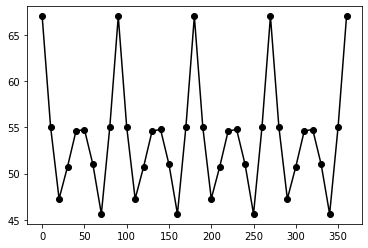

In [ ]:
plt.plot(angle_arr, accuracy_arr, '-ok')
# plt.gca().invert_xaxis()